In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Import boosting classifier
from sklearn.ensemble import GradientBoostingClassifier as GBC 

/home/shrikrishna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#Evaluation Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
#Lending Club Data
data_path = '/home/shrikrishna/Desktop/Coursera Machine Learning/Machine Learning: Classification/Week 3 Decision Tree/'

data = pd.read_csv(data_path + '/lending-club-data/lending-club-data.csv')

#Read the train and validation data
train_ind = pd.read_json('train-idx.json')
validation_ind = pd.read_json('validation-idx.json')


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
def find_missing(data):
    missing_count = data.isna().sum()
    missing_percentage = missing_count*100/data.shape[0]
    missing_data = pd.DataFrame({'Features': data.columns,
                                 'Missing Value Count': missing_count,
                                 'Missing Value Percentage': missing_percentage},
                                 columns = ['Features',\
                                           'Missing Value Count',\
                                           'Missing Value Percentage'])
    #Sort the data frame in descending order of missing values
    missing_data = missing_data.sort_values(by='Missing Value Count',\
                                            ascending = False)
    return missing_data

In [6]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [7]:
data.shape

(122607, 68)

## Create a column named 'safe_loans'  using 'bad_loans'

In [8]:
'bad_loans' in data.columns

True

In [9]:
#Safe = +1 Risky = -1
data['safe_loans'] = data['bad_loans'].apply(lambda x:1 if(x==0) else -1)
data[['safe_loans', 'bad_loans']].head()

,safe_loans,bad_loans
0,1,0
1,-1,1
2,1,0
3,1,0
4,1,0


### Selecting features

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are described in the code comments below. If you are a finance geek, the LendingClub website has a lot more details about these features.


In [10]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [11]:
## Drop the Missing Values from the selected features
data = data[[target] + features].dropna()

In [12]:
data.shape

(122578, 25)

## One Hot Encoding

In [13]:
def OHE(data):
    #Obtain the categorical features
    categorical_features = [fea for fea in data.columns\
                            if(data[fea].dtype == 'object')]
    
    #Create dummies
    dummies_data = pd.get_dummies(data[categorical_features])
    
    #Append the dummies data frame to the orignal data
    data = pd.concat([data, dummies_data], axis = 1)
    
    #Drop the categorical features
    data = data.drop(categorical_features, axis=1)
    
    return data

In [15]:
data = OHE(data)

In [16]:
data.shape

(122578, 45)

In [17]:
data.head()

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
0,1,0.4,0,11,27.65,8.14350,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
1,-1,0.8,1,1,1.00,2.39320,0.0,1.0,5.0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1.0,0,11,8.72,8.25955,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,1,0,0
3,1,0.2,0,11,20.00,8.27585,0.0,1.0,1.0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0.8,0,4,11.20,5.21533,0.0,1.0,3.0,1,...,0,0,0,0,0,0,0,0,0,1


In [18]:
OHE_features = list(set(data.columns).difference(set([target])))
target in OHE_features

False

## Reading the Training and Validation file

In [19]:
#Obtain the Train Data and Validation Data
train_data = data.iloc[train_ind[0], :]
validation_data = data.iloc[validation_ind[0], :]

In [20]:
print("Shape:-\nTrain Data:-{}\tValidation Data:-{}"\
      .format(train_data.shape, validation_data.shape))

Shape:-
Train Data:-(37219, 45)	Validation Data:-(9284, 45)


In [21]:
train_data.head()

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
1,-1,0.8,1,1,1.00,2.39320,0.0,1.0,5.0,1,...,0,0,0,0,0,0,0,0,0,0
6,-1,0.4,0,5,5.55,4.57170,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,1,0,0
7,-1,1.0,1,1,18.08,9.71600,0.0,1.0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
10,-1,0.2,1,1,10.08,12.21520,0.0,1.0,1.0,1,...,1,0,0,0,0,0,0,0,0,0
12,-1,0.4,0,4,7.06,3.90888,0.0,1.0,2.0,1,...,0,0,0,0,0,0,1,0,0,0


In [51]:
validation_data.head()

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0
60,-1,0.4,0,5,12.48,3.57024,0.0,1.0,3.0,1,...,0,0,0,0,0,0,0,1,0,0
93,-1,0.4,0,11,23.18,14.70090,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0
132,-1,0.2,0,3,7.83,11.04860,0.0,1.0,2.0,1,...,1,0,0,0,0,0,0,0,0,0


In [22]:
find_missing(train_data).head()

,Features,Missing Value Count,Missing Value Percentage
safe_loans,safe_loans,0,0.0
grade_B,grade_B,0,0.0
grade_D,grade_D,0,0.0
grade_E,grade_E,0,0.0
grade_F,grade_F,0,0.0


In [103]:
list(train_data[target])

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,


## Building The sklearn boosting classifier

In [125]:
class Modelling():
    def __init__(self, train_data, validation_data, features,\
                 target, max_depth, n_estimators):
        self.train_data = train_data
        self.validation_data = validation_data
        self.max_depth = max_depth
        self.n_trees = n_estimators
        self.features = features
        self.target = target

    def evaluate(self, actual, predicted):
        CM = confusion_matrix(actual, predicted)
        accuracy = CM.diagonal().sum()/CM.sum()
        precision = CM[1,1]/(CM[1, 0] + CM[1, 1])
        recall = CM[1,1]/(CM[0, 1] + CM[1, 1])
        print("Confusion Matrix:-\n{}" .format(CM))
        print("Accuracy:- %.2f" %(accuracy))
        print("Precision:- %.2f\nRecall:- %.2f"\
              %(precision, recall))
        
        #Return the error
        return (1-accuracy)
    
    def get_results(self, actual, predicted,\
                    predicted_probability, train_val):
        #Create a Data Frame
        result_df = pd.DataFrame({'Actual': actual,\
                                  'Predicted': predicted},\
                                  columns = ['Actual', 'Predicted'])
        
        #Evaluate the model
        print("Results of " + train_val + " data")
        error = self.evaluate(actual, predicted)
        
        #Transpose
        predicted_probability = predicted_probability.T
        
        result_df['Probability_of_negative'] = predicted_probability[0, :]
        result_df['Probability_of_positive'] = predicted_probability[1, :]
        
        return (result_df, error)
    
    def prediction(self):
        model = GBC(max_depth=self.max_depth,\
                    n_estimators=self.n_trees)
        #GBC(max_depth=6, n_estimators=5)
        model.fit(self.train_data[self.features],\
                  self.train_data[self.target])
        
        predicted_train = model.predict(self.train_data[self.features])
        predicted_validation = model.predict(\
                               self.validation_data[self.features])
                
        #Get the probability
        predicted_probability_train = model.predict_proba(\
                                self.train_data[self.features])
        predicted_probability_val = model.predict_proba(\
                                self.validation_data[self.features])
        
        #Create a resultant data frame
        results_train, error_train = self.get_results(list(self.train_data[self.target]),\
                                    predicted_train,\
                                    predicted_probability_train, 'train')
        results_val, error_val = self.get_results(list(self.validation_data[self.target]),\
                                  predicted_validation,\
                                  predicted_probability_val, 'validation')
        
        return (results_val, error_train, error_val)

In [60]:
target

'safe_loans'

In [109]:
validation_data.shape

(9284, 45)

In [129]:
modelling_obj_5 = Modelling(train_data, validation_data, OHE_features, target, 6, 5)

In [127]:
result_5, train_error_5, validation_error_5 = \
modelling_obj_5.prediction()

Results of train data
Confusion Matrix:-
[[12052  6423]
 [ 6027 12717]]
Accuracy:- 0.67
Precision:- 0.68
Recall:- 0.66
Results of validation data
Confusion Matrix:-
[[3020 1652]
 [1491 3121]]
Accuracy:- 0.66
Precision:- 0.68
Recall:- 0.65


In [128]:
print("Model 5:-\nTrain Error:- %.2f\t Validation Error:- %.2f"\
      %(train_error_5, validation_error_5))

Model 5:-
Train Error:- 0.33	 Validation Error:- 0.34


In [68]:
#Make sure to set max_depth=6 and n_estimators=5.
model_5 = GBC(max_depth=6, n_estimators=5)

In [69]:
model_5.fit(train_data[OHE_features], train_data[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Sample Validation Data

In [26]:
set(features + [target]).intersection(set(validation_data)) == \
                        set(validation_data)

False

In [27]:
set(features + [target]).intersection(set(validation_data)) == \
                        set(features + [target])

False

In [28]:
#Safe and risky validation
validation_safe_loans = validation_data.loc[validation_data['safe_loans']==+1, :]
                                            
validation_risky_loans = validation_data.loc[validation_data['safe_loans']==-1, :]
                                             

#Sample safe and risky validation (top 2 observations)
sample_validation_safe_loans = validation_safe_loans.iloc[:2, :]
sample_validation_risky_loans = validation_risky_loans.iloc[:2, :]

#Combine the sample observations
sample_validation_data = pd.concat([sample_validation_safe_loans,\
                                    sample_validation_risky_loans],\
                                  axis = 0)

In [29]:
sample_validation_data.shape

(4, 45)

### Quiz question: What percentage of the predictions on sample_validation_data did model_5 get correct?

In [30]:
model_5.predict(sample_validation_data[OHE_features])

array([ 1,  1, -1,  1])

In [44]:
def get_results(data, model):
    actual = data[target]
    
    predicted = model.predict(data[OHE_features])
    
    result_df = pd.DataFrame({'Actual': actual,\
                              'Predicted': predicted},\
                              columns = ['Actual', 'Predicted'])
    return (result_df)

In [45]:
sample_result = get_results(sample_validation_data, model_5)

### What percentage of the predictions on sample_validation_data did model_5 get correct?

In [46]:
##Percentage of Correct predictions
def get_accuracy(actual, predicted):
    mistake_count = 0
    
    for act, pred in zip(actual, predicted):
        if(act!=pred):
            mistake_count += 1
    accuracy = ((len(actual) - mistake_count)/len(actual))    
    return (accuracy)

print("Percentage of correct predictions:- %.2f"\
      %(get_accuracy(sample_result['Actual'], sample_result['Predicted'])))


Percentage of correct predictions:- 0.75


### Prediction Probabilities

12. For each row in the sample_validation_data, what is the probability (according model_5) of a loan being classified as safe? (Hint: if you are using scikit-learn, you can use the .predict_proba() method)

In [47]:
predicted_probability = model_5.predict_proba(\
                                             sample_validation_data\
                                             [OHE_features])
predicted_probability


array([[0.41642331, 0.58357669],
       [0.46949689, 0.53050311],
       [0.53807792, 0.46192208],
       [0.39591639, 0.60408361]])

In [48]:
#Transpose
predicted_probability = predicted_probability.T

result_df['Probability_of_negative'] = predicted_probability[0, :]
result_df['Probability_of_positive'] = predicted_probability[1, :]

result_df

,Actual,Predicted,Probability_of_negative,Probability_of_positive
22,1,1,0.416423,0.583577
26,1,1,0.469497,0.530503
24,-1,-1,0.538078,0.461922
41,-1,1,0.395916,0.604084


### Quiz Question: Which loan has the highest probability of being classified as a safe loan?

In [35]:
print("Loan 4")

Loan 4


### Evaluate the accuracy of the model_5 on the validation_data.

In [36]:
actual_validation = validation_data[target]
predict_validation = model_5.predict(validation_data[OHE_features])

get_accuracy(actual_validation, predict_validation)

0.6613528651443343

In [37]:
CM_validation = confusion_matrix(actual_validation, predict_validation)
CM_validation

array([[3019, 1653],
       [1491, 3121]])

### Costs of Mistakes
False negatives: Assume a cost of $10,000 per false negative.

False positives: Assume a cost of $20,000 per false positive.
    

In [38]:
TN, FP, FN, TP = CM_validation.ravel()

### What is the number of false positives on the validation data?

In [157]:
print("Number of False Positives on Validation Data:-\n" + str(FP))

Number of False Positives on Validation Data:-
1653


### 16. Calculate the cost of mistakes made by model_5 on the validation_data.

Quiz Question: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (model_5) as evaluated on the validation_set?

In [39]:
fn_cost, fp_cost = 10000, 20000
print("Cost of Mistakes = %d" %(FP*fp_cost + FN*fn_cost))

Cost of Mistakes = 47970000


### Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted safe. We can do this in a few steps:

    Step 1: Use the model_5 (the model with 5 trees) and make probability predictions for all the loans in validation_data.
    
    Step 2: Similar to what we did in the very first assignment, add the probability predictions as a column called predictions into validation_data.
    
    Step 3: Sort the data (in descreasing order) by the probability predictions.

In [55]:
result_df_val = get_results(validation_data, model_5)

predicted_probability_val = model_5.predict_proba(\
                                             validation_data\
                                             [OHE_features])

#Transpose
predicted_probability_val = predicted_probability_val.T

result_df_val['Probability_of_negative'] = predicted_probability_val[0, :]
result_df_val['Probability_of_positive'] = predicted_probability_val[1, :]

#Sort the data in descending order of probability
result_df_val = result_df_val.sort_values(by='Probability_of_positive',\
                                          ascending = False)
result_df_val.head()

,Actual,Predicted,Probability_of_negative,Probability_of_positive
8021,-1,1,0.326941,0.673059
16736,1,1,0.338532,0.661468
67183,1,1,0.338532,0.661468
27214,1,1,0.338532,0.661468
73426,1,1,0.338532,0.661468


Find the top 5 loans with the highest probability of being predicted as a safe loan.
### Quiz question: What grades are the top 5 loans?

In [160]:
top_5_loans_indx = result_df_val.head().index

In [164]:
grade_col = ''
grade_col = [col for col in data.columns if('grade' in col)]

if(grade_col!=''):
    data.loc[top_5_loans_indx.tolist(), grade_col]

In [165]:
data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
0,1,0.4,0,11,27.65,8.143500,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
1,-1,0.8,1,1,1.00,2.393200,0.0,1.0,5.0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1.0,0,11,8.72,8.259550,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,1,0,0
3,1,0.2,0,11,20.00,8.275850,0.0,1.0,1.0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0.8,0,4,11.20,5.215330,0.0,1.0,3.0,1,...,0,0,0,0,0,0,0,0,0,1
5,1,0.2,0,10,5.35,2.735750,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,0,0,0
6,-1,0.4,0,5,5.55,4.571700,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,1,0,0
7,-1,1.0,1,1,18.08,9.716000,0.0,1.0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
8,1,0.6,0,6,16.12,2.557500,0.0,1.0,2.0,1,...,1,0,0,0,0,0,0,0,0,0
9,1,1.0,0,11,10.78,6.440640,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


Repeat this exercise to find the 5 loans (in the validation_data) with the lowest probability of being predicted as a safe loan.


In [56]:
result_df_val.tail()

,Actual,Predicted,Probability_of_negative,Probability_of_positive
114781,-1,-1,0.684031,0.315969
101746,-1,-1,0.684031,0.315969
27502,-1,-1,0.687194,0.312806
58794,-1,-1,0.692666,0.307334
84508,-1,-1,0.692666,0.307334


## Effects of adding more trees

20. Train models with 10, 50, 100, 200, and 500 trees. Use the n_estimators parameter to control the number of trees. Remember to keep max_depth = 6.

In [139]:
def ensemble_util(no_trees):
    modelling_obj = Modelling(train_data, validation_data, OHE_features,\
                              target, 6, no_trees)
    
    result, train_error, validation_error = modelling_obj.prediction()
    #print("Model :-\nTrain Error:- %.2f\t Validation Error:- %.2f"\
    
    return (train_error, validation_error)

In [140]:
tree_list = [10, 50, 100, 200, 500]
resultant_error_list = list(map(ensemble_util, tree_list))
resultant_error_list

Results of train data
Confusion Matrix:-
[[12221  6254]
 [ 5966 12778]]
Accuracy:- 0.67
Precision:- 0.68
Recall:- 0.67
Results of validation data
Confusion Matrix:-
[[3056 1616]
 [1483 3129]]
Accuracy:- 0.67
Precision:- 0.68
Recall:- 0.66
Results of train data
Confusion Matrix:-
[[12999  5476]
 [ 5042 13702]]
Accuracy:- 0.72
Precision:- 0.73
Recall:- 0.71
Results of validation data
Confusion Matrix:-
[[3140 1532]
 [1388 3224]]
Accuracy:- 0.69
Precision:- 0.70
Recall:- 0.68
Results of train data
Confusion Matrix:-
[[13648  4827]
 [ 4613 14131]]
Accuracy:- 0.75
Precision:- 0.75
Recall:- 0.75
Results of validation data
Confusion Matrix:-
[[3173 1499]
 [1387 3225]]
Accuracy:- 0.69
Precision:- 0.70
Recall:- 0.68
Results of train data
Confusion Matrix:-
[[14452  4023]
 [ 3894 14850]]
Accuracy:- 0.79
Precision:- 0.79
Recall:- 0.79
Results of validation data
Confusion Matrix:-
[[3183 1489]
 [1423 3189]]
Accuracy:- 0.69
Precision:- 0.69
Recall:- 0.68
Results of train data
Confusion Matrix:-
[[1

[(0.3283269297939224, 0.33380008616975443),
 (0.282597598001021, 0.3145196036191297),
 (0.2536338966656815, 0.3108573890564412),
 (0.21271393643031788, 0.3136579060749677),
 (0.13168005588543485, 0.31010340370529943)]

In [141]:
#The resultant error list will contain tuples 
resultant_error_list

[(0.3283269297939224, 0.33380008616975443),
 (0.282597598001021, 0.3145196036191297),
 (0.2536338966656815, 0.3108573890564412),
 (0.21271393643031788, 0.3136579060749677),
 (0.13168005588543485, 0.31010340370529943)]

In [149]:
#First Row ----> Training Error
#Second Row -----> Validation Error

resultant_error_list = np.array(resultant_error_list).T

error_per_tree = pd.DataFrame({'Training Error': resultant_error_list[0],\
                               'Validation Error': resultant_error_list[1]},
                              columns = ['Training Error',\
                                        'Validation Error'],\
                              index = tree_list)
error_per_tree

,Training Error,Validation Error
10,0.328327,0.333800
50,0.282598,0.314520
100,0.253634,0.310857
200,0.212714,0.313658
500,0.131680,0.310103


### 21. Evaluate the accuracy of the 10, 50, 100, 200, and 500 tree models on the validation_data.

Quiz Question: Which model has the best accuracy on the validation_data?

Quiz Question: Is it always true that the model with the most trees will perform best on test data?


In [152]:
print("Best Accuracy on Validataion Data:-")
error_per_tree.loc[error_per_tree['Validation Error']==\
                   min(error_per_tree['Validation Error']), :].index[0]

Best Accuracy on Validataion Data:-


500

In [153]:
#Quiz Question: Is it always true that the model with the most trees
#will perform best on test data?
print("No")

No


### Plot the training and validation error vs. number of trees


In [142]:
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

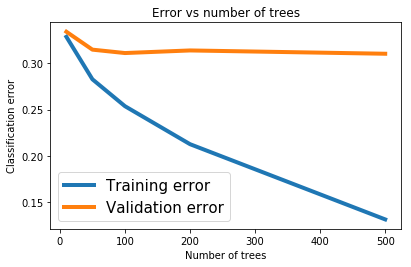

In [154]:
training_errors = list(error_per_tree['Training Error'])
validation_errors = list(error_per_tree['Validation Error'])

plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

### Quiz question: Does the training error reduce as the number of trees increases?

In [155]:
print("Yes")

Yes


### Quiz question: Is it always true that the validation error will reduce as the number of trees increases?

In [156]:
print("No")

No
